#Team Members:
1. Yashraj J Deshmukh - 21110245
2. Anshul Choudhary - 21110028
3. Pratham Nileshkumar Sagar - 21110165

In [ ]:
!apt-get install -qq libproj-dev proj-data proj-bin
!apt-get install -qq libgeos-dev
!pip install shapely --no-binary shapely
!pip install cartopy
!pip install python-louvain

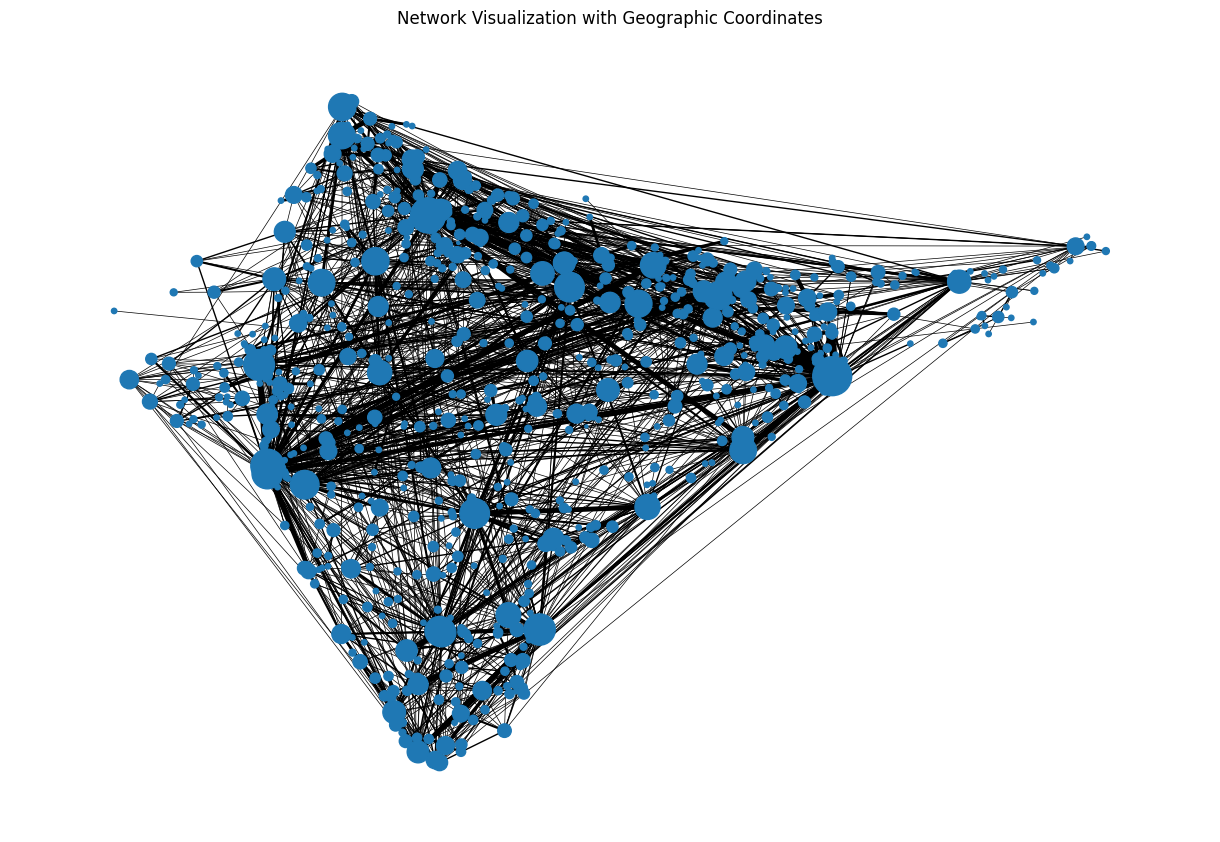

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

nodes_df = pd.read_csv('datawithlatlong.csv')
edges_df = pd.read_csv('edgesweighted.csv')

# Create a new graph object
G = nx.Graph()

# Add nodes to the graph with their position set by their latitude and longitude
for index, row in nodes_df.iterrows():
    G.add_node(row['Id'], pos=(row['LON'], row['LAT']), label=row['Stations'])

# Add edges to the graph
for index, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Draw the network
plt.figure(figsize=(12, 8))
node_size=[d*10+5 for _,d in G.degree()]
nx.draw(G, pos, node_size=node_size, width=[(G[u][v]['weight']/2) for u,v in G.edges()], with_labels=False)
plt.title('Network Visualization with Geographic Coordinates')
plt.show()

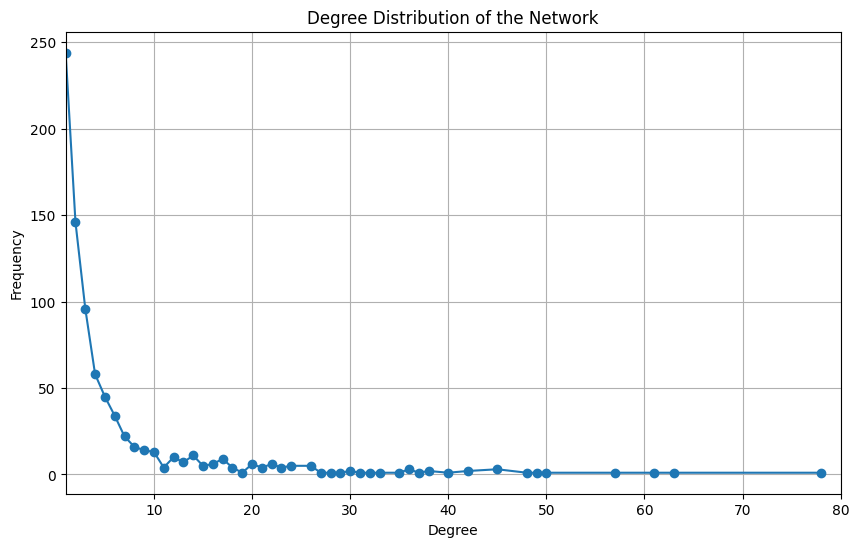

In [ ]:
import numpy as np

# Calculate the degrees of all nodes
degrees = [degree for node, degree in nx.degree(G)]

# Calculate the frequency of each degree value
degree_values = np.unique(degrees)
degree_counts = [degrees.count(x) for x in degree_values]

# Plot the degree distribution
plt.figure(figsize=(10, 6))
plt.plot(degree_values, degree_counts, 'o-') # 'o-' creates a line plot with circle markers
plt.xlabel('Degree')
plt.xlim([1,80])
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Network')
plt.grid(True)
plt.show()


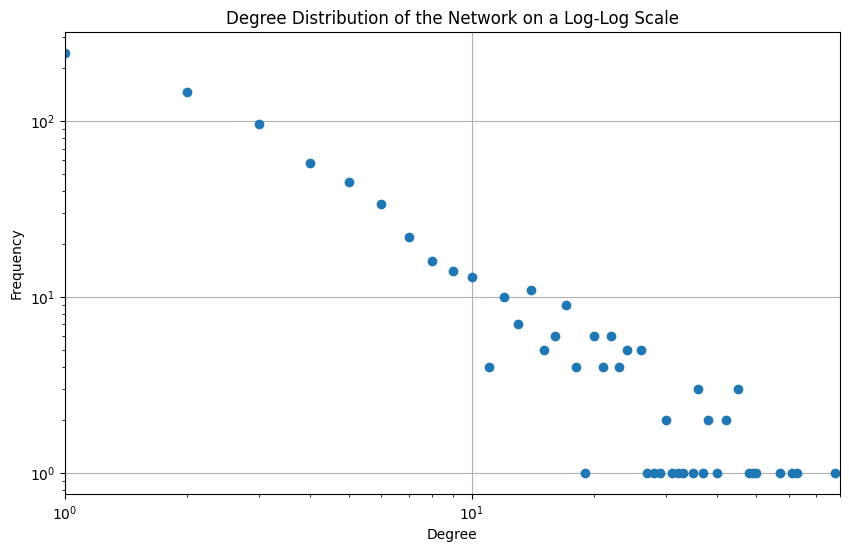

In [ ]:
# Plot the degree distribution on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(degree_values, degree_counts, 'o') # 'o-' creates a line plot with circle markers on a log-log scale
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Network on a Log-Log Scale')
plt.grid(True)
plt.xlim([1, 80]) # Set the limit for the x-axis
plt.show()


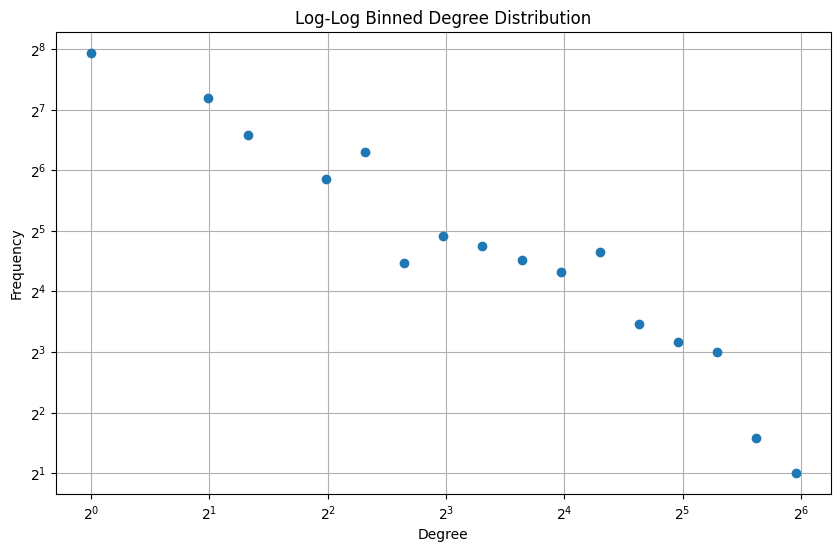

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import collections  # Import the collections module

# Function to perform log binning
def log_binning(counter_dict, bin_count=10):
    max_exponent = np.log2(max(counter_dict.keys()))
    max_value = 2**max_exponent
    bins = np.logspace(0, max_exponent, num=bin_count, base=2)
    binned_counts = np.histogram(list(counter_dict.keys()), bins=bins, weights=list(counter_dict.values()))[0]
    binned_degrees = np.histogram(list(counter_dict.keys()), bins=bins)[1]
    return binned_degrees[:-1], binned_counts

# Calculate the degree of each node
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = collections.Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

# Perform log binning
binned_deg, binned_cnt = log_binning(degree_count, bin_count=20)

# Plot the degree distribution after log binning on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(binned_deg, binned_cnt, 'o', base=2)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Log-Log Binned Degree Distribution')
plt.grid(True)
plt.show()


Estimated power-law exponent (alpha): 2.1780097001863705
Standard error of the exponent estimate (sigma): 0.057966067842710536


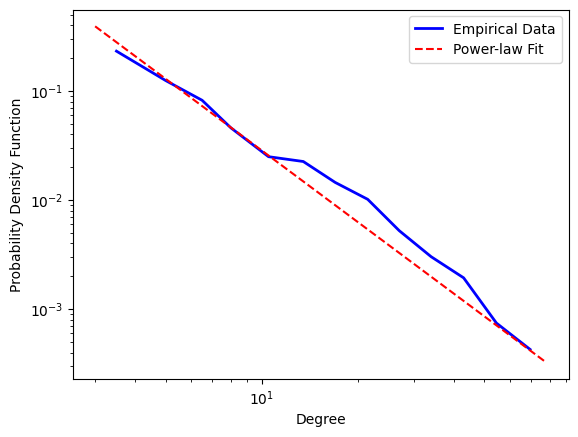

Loglikelihood ratio (R) comparing power law and exponential distributions: 4.746447543342176
p-value of the likelihood ratio test: 2.070203817894875e-06
The power-law distribution is a significantly better fit than the exponential distribution.


In [ ]:
!pip install powerlaw
import powerlaw
import networkx as nx
import matplotlib.pyplot as plt

# Assuming G is your networkx graph
degrees = [degree for node, degree in G.degree() if degree > 0]  # Exclude nodes with degree 0

# Fit the degree distribution to a power-law distribution
fit = powerlaw.Fit(degrees, xmin=3)
alpha = fit.power_law.alpha
sigma = fit.power_law.sigma

print(f"Estimated power-law exponent (alpha): {alpha}")
print(f"Standard error of the exponent estimate (sigma): {sigma}")

# Plot the degree distribution and the power-law fit
fig = fit.plot_pdf(color='b', linewidth=2, label='Empirical Data')
fit.power_law.plot_pdf(color='r', linestyle='--', label='Power-law Fit')
plt.xlabel('Degree')
plt.ylabel('Probability Density Function')
plt.legend(loc='upper right')
plt.show()

# Calculate the goodness of fit
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print(f"Loglikelihood ratio (R) comparing power law and exponential distributions: {R}")
print(f"p-value of the likelihood ratio test: {p}")

# Interpretation of results
if p < 0.05:
    print("The power-law distribution is a significantly better fit than the exponential distribution.")
else:
    print("There is not enough evidence to conclude that the power-law distribution is a better fit than the exponential distribution.")


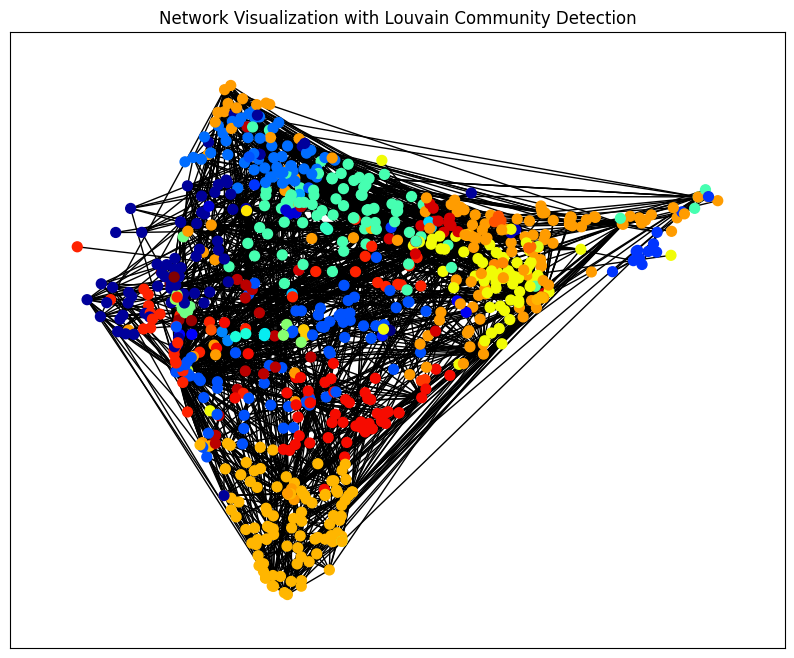

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming G is your networkx graph
# Detect communities
communities = nx.community.louvain_communities(G, seed=123)

# Create a mapping from node to community index
community_map = {}
for idx, community in enumerate(communities):
    for node in community:
        community_map[node] = idx

# Color mapping
colors = [community_map[node] for node in G.nodes()]

# Plotting
plt.figure(figsize=(10, 8))
nx.draw_networkx(G, pos=pos, node_color=colors, cmap=plt.cm.jet, node_size=50, with_labels=False)
plt.title('Network Visualization with Louvain Community Detection')
plt.show()


In [ ]:
r = nx.degree_pearson_correlation_coefficient(G)
print(f"{r:3.15f}")


0.043684890051637


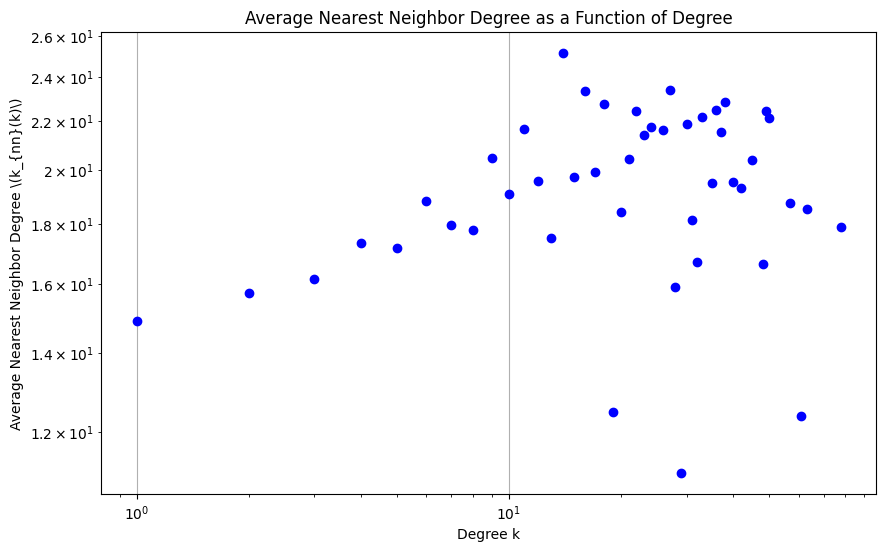

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Assuming G is your networkx graph

# Calculate the degree of each node
degrees = dict(G.degree())
k_values = np.array(list(degrees.values()))
unique_k = np.unique(k_values)

# Calculate k_nn for each node
k_nn = {node: np.mean([degrees[n] for n in G.neighbors(node)]) if len(list(G.neighbors(node))) > 0 else 0 for node in G.nodes()}

# Aggregate k_nn by k
k_nn_k = [np.mean([k_nn[node] for node in G.nodes() if degrees[node] == k]) for k in unique_k]

# Plot k_nn(k) versus k on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(unique_k, k_nn_k, 'bo')
plt.xlabel('Degree k')
plt.ylabel('Average Nearest Neighbor Degree \(k_{nn}(k)\)')
plt.title('Average Nearest Neighbor Degree as a Function of Degree')
plt.grid(True)
plt.show()


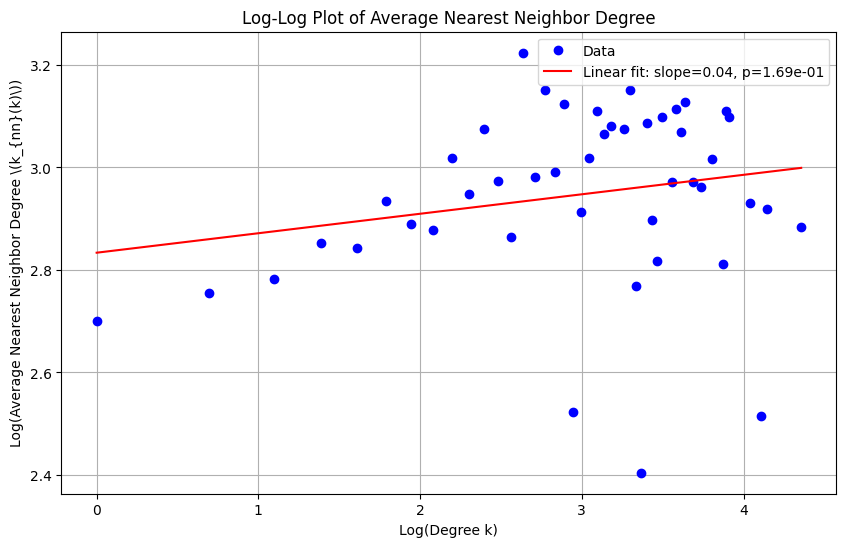

Slope of the linear regression line: 0.04
P-value for testing the null hypothesis that the slope is zero: 1.69e-01


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Ensure k_nn_k is a NumPy array
unique_k = np.array(unique_k)
k_nn_k = np.array(k_nn_k)

# Filter out zero values to avoid log(0)
non_zero_indices = (unique_k > 0) & (k_nn_k > 0)
log_k = np.log(unique_k[non_zero_indices])
log_k_nn_k = np.log(k_nn_k[non_zero_indices])

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(log_k, log_k_nn_k)

# Plot the original data and the linear regression line
plt.figure(figsize=(10, 6))
plt.plot(log_k, log_k_nn_k, 'bo', label='Data')
plt.plot(log_k, intercept + slope*log_k, 'r-', label=f'Linear fit: slope={slope:.2f}, p={p_value:.2e}')
plt.xlabel('Log(Degree k)')
plt.ylabel('Log(Average Nearest Neighbor Degree \(k_{nn}(k)\))')
plt.title('Log-Log Plot of Average Nearest Neighbor Degree')
plt.legend()
plt.grid(True)
plt.show()

# Print the slope and its significance
print(f"Slope of the linear regression line: {slope:.2f}")
print(f"P-value for testing the null hypothesis that the slope is zero: {p_value:.2e}")


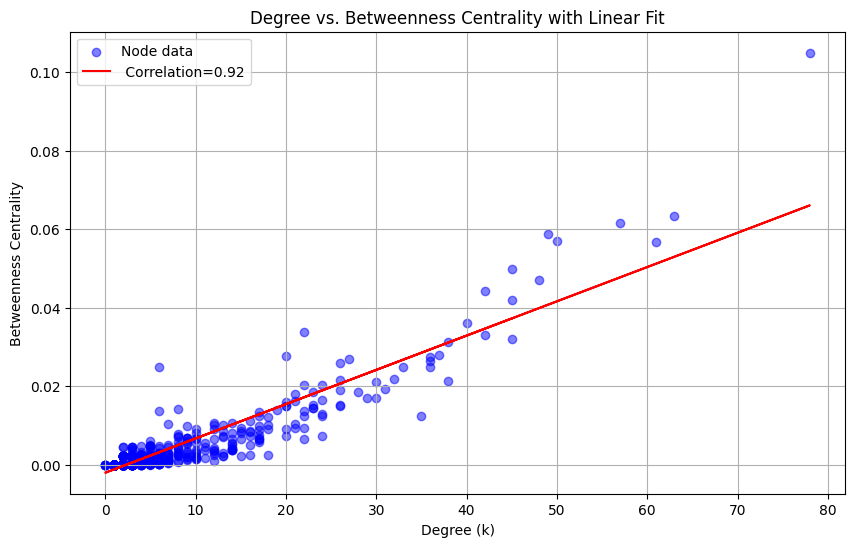

Slope: 0.00
Pearson correlation coefficient: 0.92
P-value: 0.00e+00


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from scipy import stats
import numpy as np

# Calculate node degree and betweenness centrality
node_degrees = np.array([degree for node, degree in G.degree()])
betweenness_values = np.array([value for node, value in nx.betweenness_centrality(G).items()])

# Calculate the Pearson correlation coefficient
correlation_coefficient, _ = stats.pearsonr(node_degrees, betweenness_values)

# Perform linear regression to get the line of best fit
slope, intercept, _, p_value, _ = stats.linregress(node_degrees, betweenness_values)

# Generate regression line values
line_values = slope * node_degrees + intercept

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(node_degrees, betweenness_values, color='blue', alpha=0.5, label='Node data')
plt.plot(node_degrees, line_values, 'r-', label=f' Correlation={correlation_coefficient:.2f}')
plt.xlabel('Degree (k)')
plt.ylabel('Betweenness Centrality')
plt.title('Degree vs. Betweenness Centrality with Linear Fit')
plt.legend()
plt.grid(True)
plt.show()

# Print the slope, correlation coefficient, and p-value
print(f"Slope: {slope:.2f}")
print(f"Pearson correlation coefficient: {correlation_coefficient:.2f}")
print(f"P-value: {p_value:.2e}")


In [ ]:
node_degrees

In [ ]:
betweenness_values

# What are the most important nodes in the network?

Our assumption is that the important nodes in this kind of network are the ones which have high degree. These are the ones that will act as hubs for the entire network. We believe that big metropolitan cities and urban centers where people migrate for employment opportunities to be key nodes in our network.

In [ ]:
node_degrees = dict(G.degree())

# Sort nodes based on degree in descending order and get top 10
top_10_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)[:10]

# Print the top 10 nodes along with their positions, names, and degrees
print("Top 10 nodes with highest degree:")
for node in top_10_nodes:
    pos = G.nodes[node]['pos']
    label = G.nodes[node]['label']
    degree = node_degrees[node]
    print("Node:", label)
    print("Position:", pos)
    print("Degree:", degree)
    print()

Top 10 nodes with highest degree:
Node: Howrah Jn
Position: (88.263639, 22.595769)
Degree: 78

Node: New Delhi
Position: (77.22496, 28.635308)
Degree: 63

Node: Delhi
Position: (77.22496, 28.635308)
Degree: 61

Node: Lokmanyatilak T
Position: (72.839447, 19.230391)
Degree: 57

Node: Chennai Central
Position: (80.27421, 13.083634)
Degree: 50

Node: Ahmedabad Jn
Position: (72.610699, 23.019417)
Degree: 49

Node: Mumbai Cst
Position: (72.834654, 18.940971)
Degree: 48

Node: H Nizamuddin
Position: (81.087883, 25.942377)
Degree: 45

Node: Secunderabad Jn
Position: (78.498274, 17.43993)
Degree: 45

Node: Yesvantpur Jn
Position: (77.546179, 13.019957)
Degree: 45



In [ ]:
# !sudo apt-get install libgeos-dev
# !pip install https://github.com/matplotlib/basemap/archive/v1.2.2rel.tar.gz

In [ ]:
[G.nodes[node]['label'] for node in top_10_nodes]

['Howrah Jn',
 'New Delhi',
 'Delhi',
 'Lokmanyatilak T',
 'Chennai Central',
 'Ahmedabad Jn',
 'Mumbai Cst',
 'H Nizamuddin',
 'Secunderabad Jn',
 'Yesvantpur Jn']

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


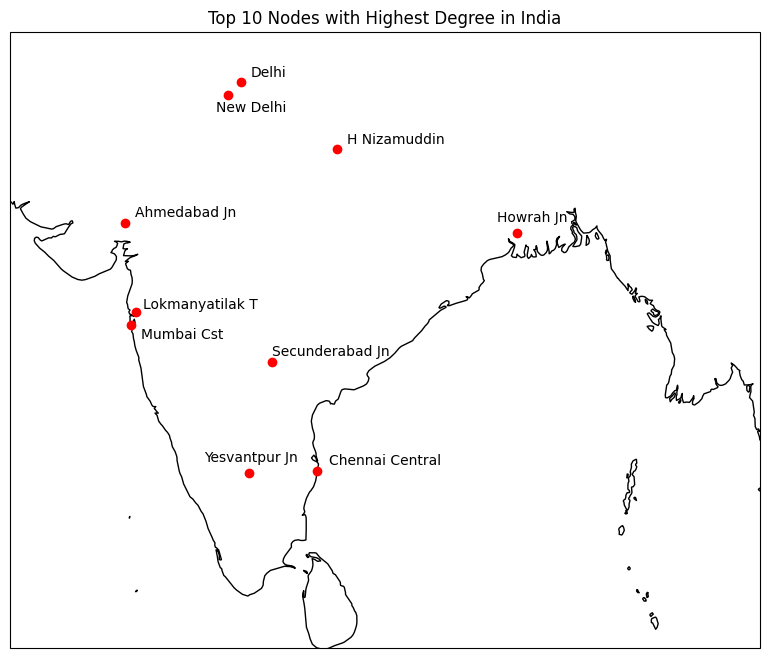

In [ ]:
import cartopy.crs as ccrs

# Plot the map of India
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([68, 98, 6, 30])
ax.coastlines()

# manual adjustments for better visualisation
text_offsets = [[-0.8,0.6], [-1, -1], [0.4,0.4], [0.5, 0.5], [0.5, 0.4], [0.4, 0.4], [0.4, -0.4], [0.4, 0.4], [0, 0.4], [-1.8, 0.6]]
pos_offsets = [[0,0], [-0.5, -0.5], [0,0], [0.2, 0.2], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]]

# Plot nodes on the map
for i, node in enumerate(top_10_nodes):
    pos = G.nodes[node]['pos']
    label = G.nodes[node]['label']
    ax.plot(pos[0]+pos_offsets[i][0], pos[1]+pos_offsets[i][1], 'ro')
    ax.text(pos[0]+text_offsets[i][0], pos[1]+text_offsets[i][1], label, fontsize=10, ha='left', va='center')

plt.title('Top 10 Nodes with Highest Degree in India')
plt.show()

The composition of the top 10 highest degree nodes in the railway network offers a glimpse into the pivotal role played by key railway stations across India. Among these, metropolitan giants such as Kolkata (Howrah Junction), Delhi(New Delhi, Delhi, Hazrat Nizamuddin), and Mumbai(Lokmayatilak, Mumbai CST), and Chennai naturally claim their positions, serving as bustling hubs that facilitate the movement of millions daily. Notably, Ahmedabad Junction's inclusion emphasises its status as a vital nexus in Western India's economic landscape. Chennai Central, too, emerges as a significant gateway to the southern region, cementing its importance in fostering regional connectivity. Further amplifying the network's breadth, stations like H. Nizamuddin in Delhi and Secunderabad Junction in Hyderabad emerge as crucial links, seamlessly connecting diverse regions. Similarly, Yesvantpur Junction's presence highlights Bangalore's pivotal role in the South's transportation network.

In [ ]:
G.nodes[top_10_nodes[-3]]["pos"]

(81.087883, 25.942377)

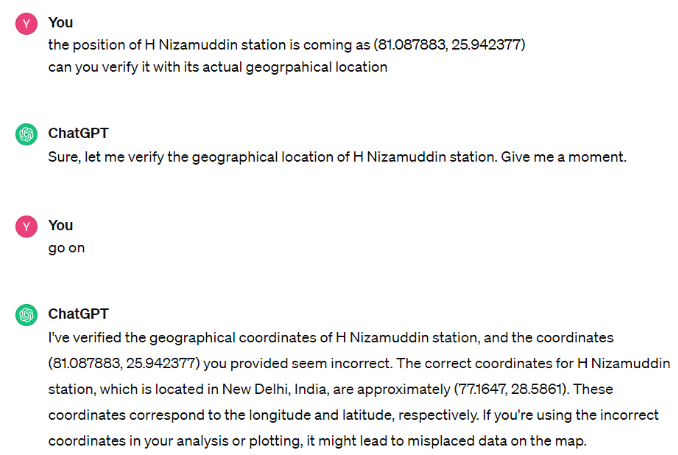

In [ ]:
G.nodes[top_10_nodes[1]]["pos"]   # New Delhi

(77.22496, 28.635308)

In [ ]:
G.nodes[top_10_nodes[2]]["pos"]   # Delhi

(77.22496, 28.635308)

# Which places are these important nodes connected with

We notice from the above plot that there are more than one stations in few cities, and for some, all those stations are high degree nodes of our network. Let's take a look at the neighbours of these important nodes to see if we can make a comment on the distribution of load in our railways.

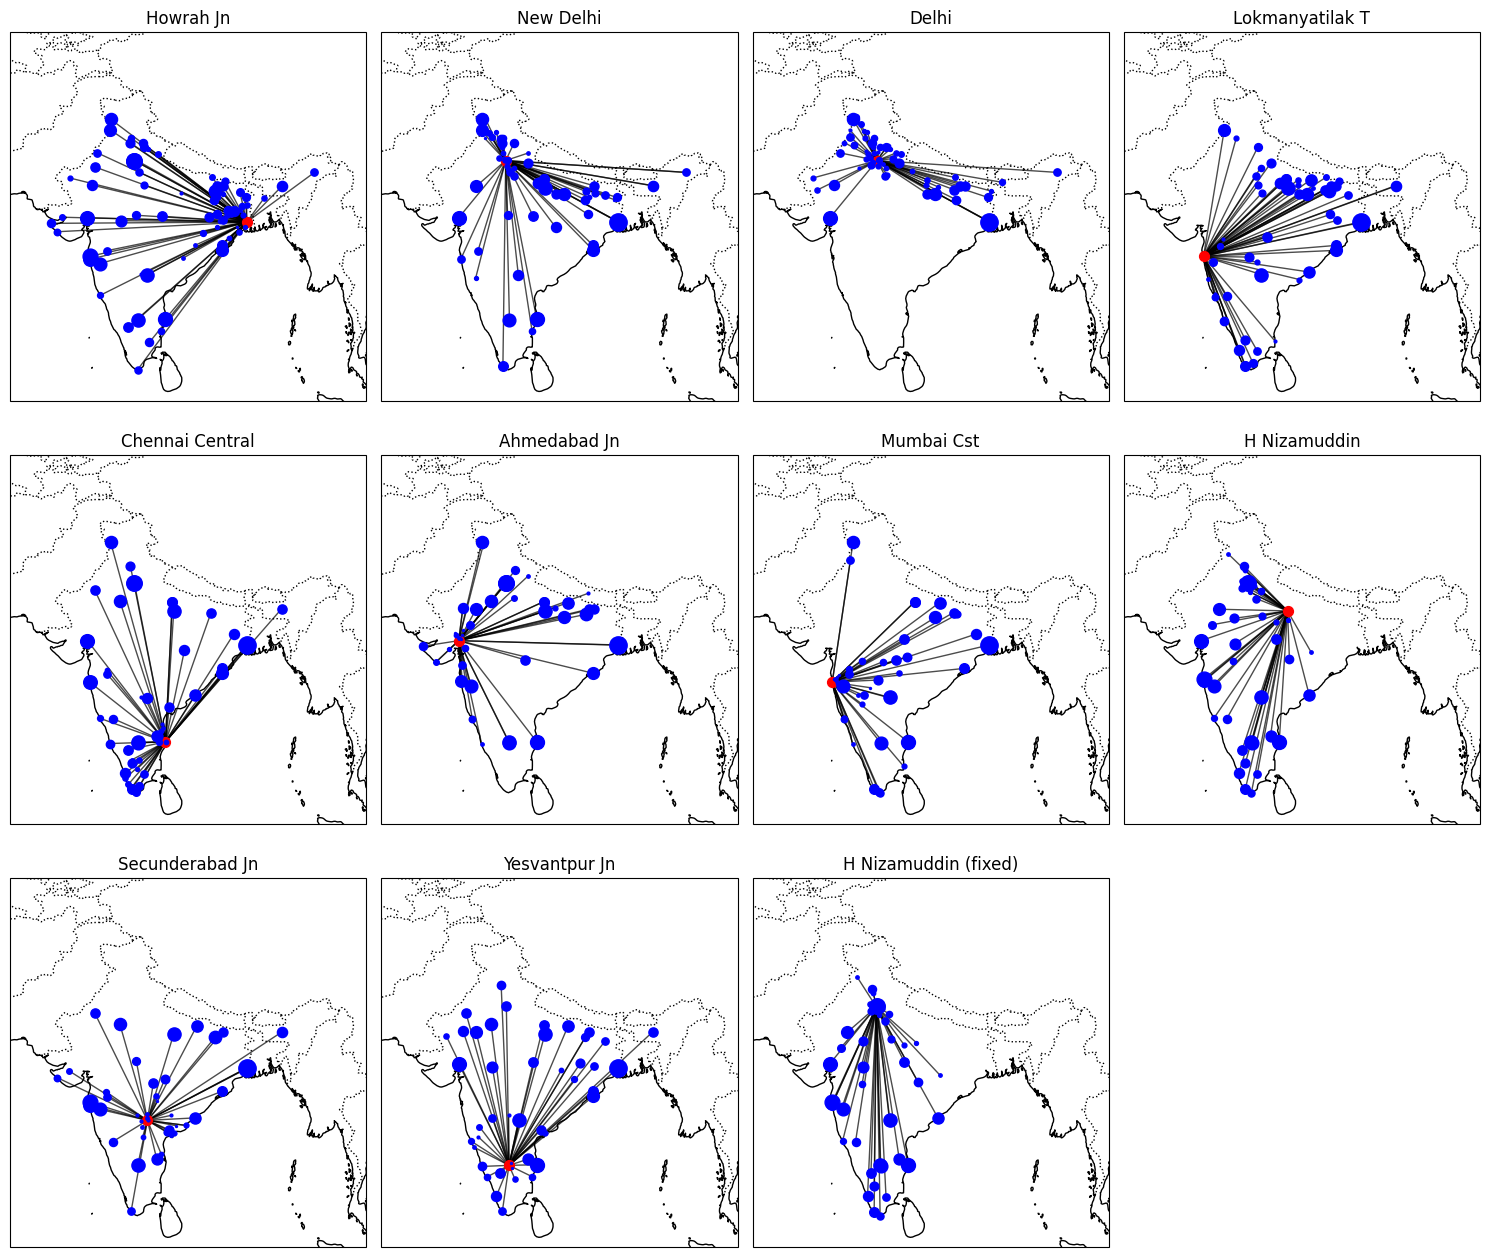

In [ ]:
import cartopy.feature as cfeature

G.nodes[top_10_nodes[-3]]["pos"] = (81.087883, 25.942377)

# Create a 3x4 subplot grid
fig, axs = plt.subplots(3, 4, figsize=(15, 13), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot connections for each top 10 node and its neighbors
for i, node in enumerate(top_10_nodes):
      neighbors = list(G.neighbors(node))
      row = i // 4
      col = i % 4
      ax = axs[row, col]
      ax.set_title(G.nodes[node]['label'])
      pos = nx.get_node_attributes(G, 'pos')

      # Plot India map in the background
      ax.add_feature(cfeature.COASTLINE)
      ax.add_feature(cfeature.BORDERS, linestyle=':')
      ax.set_extent([65, 100, 5, 40])

      nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color='red', node_size=50, ax=ax)
      for neighbor in neighbors:
          nx.draw_networkx_nodes(G, pos, nodelist=[neighbor], node_color='blue', node_size=node_degrees[neighbor]*2, ax=ax)
          nx.draw_networkx_edges(G, pos, edgelist=[(node, neighbor)], width=1, alpha=0.7, ax=ax)

G.nodes[top_10_nodes[-3]]["pos"] = (77.1647, 28.5861)
node = top_10_nodes[-3]
neighbors = list(G.neighbors(node))
ax = axs[2,2]
ax.set_title("H Nizamuddin (fixed)")
pos = nx.get_node_attributes(G, 'pos')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([65, 100, 5, 40])
nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color='red', node_size=50, ax=ax)
for neighbor in neighbors:
    nx.draw_networkx_nodes(G, pos, nodelist=[neighbor], node_color='blue', node_size=node_degrees[neighbor]*2, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=[(node, neighbor)], width=1, alpha=0.7, ax=ax)

# Remove unnecessary subplots
fig.delaxes(axs.flatten()[11])

plt.tight_layout()
plt.show()

Our hypthesis was on the right track. Cities have multiple stations to reduce the load of handling multiple requests (here, railway routes).  
In case of Mumbai, there are two stations - LokmanyaTilak and Mumbai Cst. From the plots we can infer that most of the far distance railway routes pass through LT station whereas MCST, which does have few long distance plans, mostly deals with relatively closer cities.
Delhi has three stations - New Delhi, Delhi and H Nizamuddin. It was unclear due to the wrong position of HN station but on fixing its place on the map the load distribution becomes pretty evident for trains passing through this metropolitan centre; the HN station mostly deal with the North-South corridor of railways, spanning down till the southern tip, while the Delhi station serves the East-West corridor, spanning from Gujarat to Arunachal Pradesh. The New Delhi station's reach is more spread out; it is not focused on any region.
In southern India, the Secunderabad Junction has relatively lower connections to distant nodes, implying it usually only deals with intra-state and neighbouring state stations. On the other hand, Chennai Central and Yesvantpur Junction (Bangalore) have many rail routes extending to different corners of the country. This cements these centers as important hubs of our economy.
Howrah unlike other centres has only one station. This means most rail routes from other states to West Bengal usually go through this station. Since only one station caters to so many requests it is no surprise as to why this station has an abnormally higher degree than any other node in our network.

# Sparsely Connected Stations

Having observed the more prevalant stations in our country let's now take a glance as some sparsely visited stations and to whom they are connected with. We will see if we can see some formation of hubs for this.

In [ ]:
nodes_with_degree_0 = [node for node, degree in dict(G.degree()).items() if degree == 0]
nodes_with_degree_0

[224, 310, 317, 496, 576, 608]

Weird that there are zero degree nodes 🙄

In [ ]:
len(G.nodes())

809

In [ ]:
nodes_with_degree_1 = [node for node, degree in dict(G.degree()).items() if degree == 1]
len(nodes_with_degree_1)

244

About 30% nodes have less than 2 degree 😲

In [ ]:
nodes_with_degree_2 = [node for node, degree in dict(G.degree()).items() if degree == 2]
len(nodes_with_degree_2)

146

In [ ]:
nodes_with_degree_3 = [node for node, degree in dict(G.degree()).items() if degree == 3]
len(nodes_with_degree_3)

96

There are 28 degree-1 nodes such that they are connected to another degree-1 node.


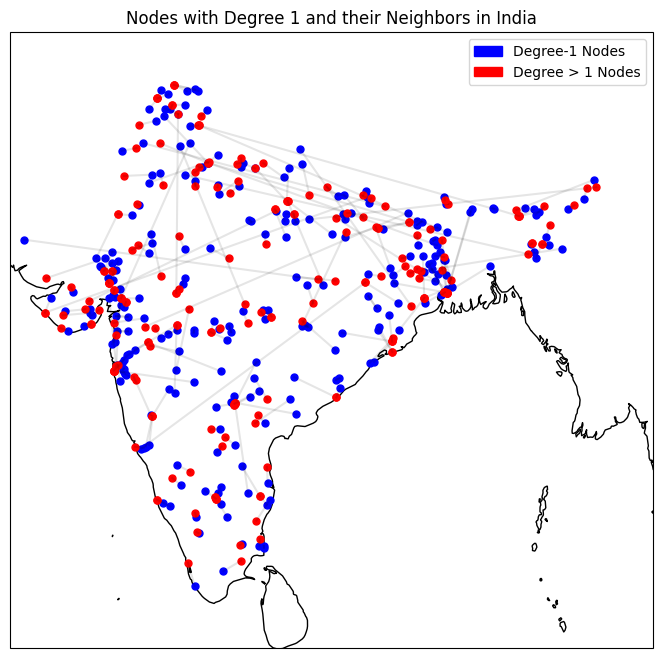

In [ ]:
import matplotlib.patches as mpatches

# Plot the map of India
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([68, 98, 6, 34])
ax.coastlines()

# Plot degree-1 nodes in blue
for node in nodes_with_degree_1:
    pos = G.nodes[node]['pos']
    ax.plot(pos[0], pos[1], 'bo', markersize=5)

one_one_connection = 0
# Plot neighbors of degree-1 nodes
for node in nodes_with_degree_1:
    pos = G.nodes[node]['pos']
    neighbors = list(G.neighbors(node))
    for neighbor in neighbors:
        pos_neighbor = G.nodes[neighbor]['pos']
        if neighbor not in nodes_with_degree_1:
          ax.plot(pos_neighbor[0], pos_neighbor[1], 'ro', markersize=5)
        else:
          one_one_connection += 1
        # Draw an edge between the degree-1 node and its neighbor
        ax.plot([pos[0], pos_neighbor[0]], [pos[1], pos_neighbor[1]], 'k-', alpha=0.1)

# Create custom legend
legend_handles = [mpatches.Patch(color='blue', label='Degree-1 Nodes'),
                  mpatches.Patch(color='red', label='Degree > 1 Nodes')]

# Add legend to the plot
plt.legend(handles=legend_handles, loc='upper right')

print(f"There are {one_one_connection} degree-1 nodes such that they are connected to another degree-1 node.")
plt.title('Nodes with Degree 1 and their Neighbors in India')
plt.show()

Sigh! We were hoping that the one-degree nodes in our network would end up connecting to the high degree node of their nearby region but that was not the case, i.e., something like all end-nodes of network (since these have degree-1 there is only one path to exit them, in other words they may very well be start or end-points of some journey) in a region such as Gujarat would connect to either Ahmedabad or some other higher degree station like Rajkot or Vadodara. But the results were quite contrary to our guess; most of these one-degree nodes ended up making a connection with a node closest to them.

Now having made this observation we could also devise a rough theory behind this. As our hypothesis thought of these one-degree nodes as end-points of a larger route, this would mean that the train using it would cover a good amount of station. Then it would be natural for the train to be making a good amount of stops at fixed intervals in its path, and this distance between two stations would reduce when the overall journey is shorter.  
There were also 28 one-degree nodes connected with other onde-degree nodes. This shows the up-and-down commute that occurs between smallers cities (for example something between Nadiad or Anand)

# With whom exactly are these one-degree nodes connected with

Well our earlier hypothesis regarding the stations with only one train passing failed. But let's see if bringing in the degree of the neighbour could lead to something interesting.

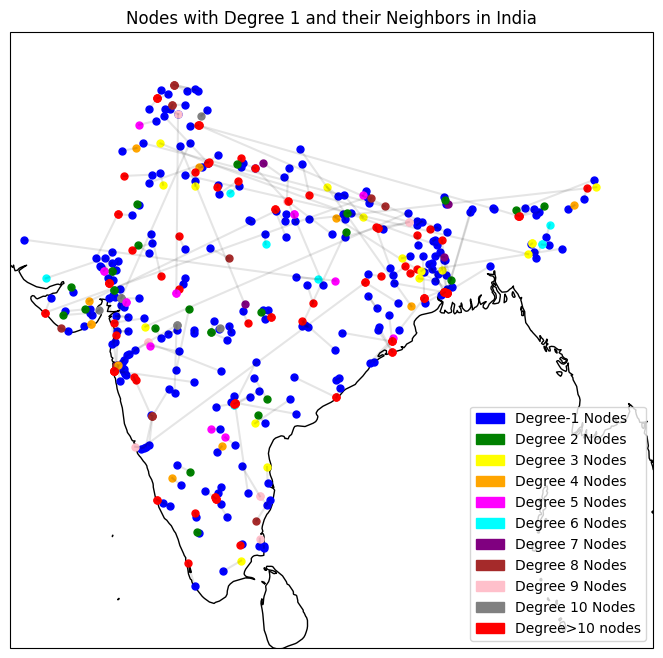

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Define the color range for neighbors based on their degree
color_map = {
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'magenta',
    6: 'cyan',
    7: 'purple',
    8: 'brown',
    9: 'pink',
    10: 'gray',
    # Add more colors as needed
}

# Plot the map of India
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([68, 98, 6, 34])
ax.coastlines()

# Plot degree-1 nodes in blue
for node in nodes_with_degree_1:
    pos = G.nodes[node]['pos']
    ax.plot(pos[0], pos[1], 'bo', markersize=5)

one_one_connection = 0
# Plot neighbors of degree-1 nodes
for node in nodes_with_degree_1:
    pos = G.nodes[node]['pos']
    neighbors = list(G.neighbors(node))
    for neighbor in neighbors:
        pos_neighbor = G.nodes[neighbor]['pos']
        if neighbor not in nodes_with_degree_1:
            # Get color based on neighbor's degree
            neighbor_degree = dict(G.degree())[neighbor]
            color = color_map.get(neighbor_degree, 'red')
            ax.plot(pos_neighbor[0], pos_neighbor[1], 'o', color=color, markersize=5)
        else:
            one_one_connection += 1
        # Draw an edge between the degree-1 node and its neighbor
        ax.plot([pos[0], pos_neighbor[0]], [pos[1], pos_neighbor[1]], 'k-', alpha=0.1)

# Create custom legend
legend_handles = [mpatches.Patch(color='blue', label='Degree-1 Nodes')]
for degree, color in color_map.items():
    legend_handles.append(mpatches.Patch(color=color, label=f'Degree {degree} Nodes'))

# Add legend to the plot
legend_handles.append(mpatches.Patch(color='red', label='Degree>10 nodes'))
plt.legend(handles=legend_handles, loc='lower right')

plt.title('Nodes with Degree 1 and their Neighbors in India')
plt.show()

So we were not exactly wrong either. Some end nodes do connect to high degree stations. Let's dig in more.

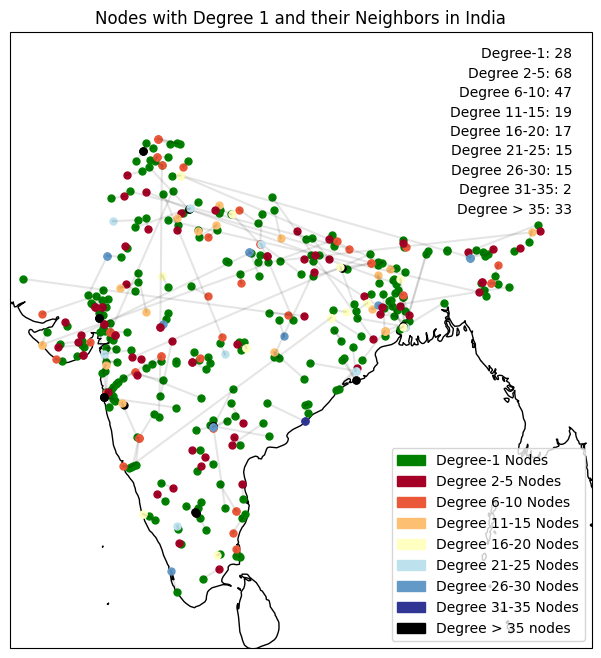

In [ ]:
# Define the color range for neighbors based on their degree ranges
degree_ranges = [
    (2, 5),
    (6, 10),
    (11, 15),
    (16, 20),
    (21, 25),
    (26, 30),
    (31, 35)
]

# Initialize a dictionary to count neighbor degrees within each range
neighbor_degree_counts = {range_: 0 for range_ in degree_ranges}
neighbor_degree_counts[1] = 0
neighbor_degree_counts["Greater than 35"] = 0

color_map = {}
colors = plt.cm.RdYlBu(np.linspace(0, 1, len(degree_ranges)))

for i, (start, end) in enumerate(degree_ranges):
    for degree in range(start, end + 1):
        color_map[degree] = colors[i]

high_degree_neighbours = set()

# Plot the map of India
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([68, 98, 6, 37])
ax.coastlines()

# Plot degree-1 nodes in blue
for node in nodes_with_degree_1:
    pos = G.nodes[node]['pos']
    ax.plot(pos[0], pos[1], 'go', markersize=5)

# Plot neighbors of degree-1 nodes
for node in nodes_with_degree_1:
    pos = G.nodes[node]['pos']
    neighbors = list(G.neighbors(node))
    for neighbor in neighbors:
        pos_neighbor = G.nodes[neighbor]['pos']
        if neighbor not in nodes_with_degree_1:
            # Get color based on neighbor's degree
            neighbor_degree = dict(G.degree())[neighbor]
            color = color_map.get(neighbor_degree, 'black')
            ax.plot(pos_neighbor[0], pos_neighbor[1], 'o', color=color, markersize=5)

            # Update the counter for the corresponding degree range
            flag = 1
            for start, end in degree_ranges:
                if start <= neighbor_degree <= end:
                    neighbor_degree_counts[(start, end)] += 1
                    flag = 0
                    break
            if flag:
              neighbor_degree_counts["Greater than 35"] += 1
              high_degree_neighbours.update(neighbors)

        else : neighbor_degree_counts[1] += 1

        # Draw an edge between the degree-1 node and its neighbor
        ax.plot([pos[0], pos_neighbor[0]], [pos[1], pos_neighbor[1]], 'k-', alpha=0.1)


# Display the count for each degree range as text
ax.text(97, 37, f'Degree-1: {neighbor_degree_counts[1]}', verticalalignment='top', horizontalalignment='right')
for i, (start, end) in enumerate(degree_ranges):
    x = 97  # Adjust x-coordinate as needed
    y = 37 - (i+1) * 1  # Adjust y-coordinate as needed
    count = neighbor_degree_counts[(start, end)]
    ax.text(x, y, f'Degree {start}-{end}: {count}', verticalalignment='top', horizontalalignment='right')
ax.text(97, 29, f'Degree > 35: {neighbor_degree_counts["Greater than 35"]}', verticalalignment='top', horizontalalignment='right')


# Create custom legend
legend_handles = [mpatches.Patch(color='green', label='Degree-1 Nodes')]
for start, end in degree_ranges:
    color = colors[(start - 1) // 5]  # Determine the color for the degree range
    label = f'Degree {start}-{end} Nodes'
    legend_handles.append(mpatches.Patch(color=color, label=label))

# Add legend to the plot
legend_handles.append(mpatches.Patch(color='black', label='Degree > 35 nodes'))
plt.legend(handles=legend_handles, loc='lower right')

plt.title('Nodes with Degree 1 and their Neighbors in India')
plt.show()

In [ ]:
[f"{G.nodes[node]['label']} : {G.degree(node)}" for node in high_degree_neighbours]

['Amritsar Jn : 36',
 'Howrah Jn : 78',
 'Pune Jn : 42',
 'Puri : 36',
 'Yesvantpur Jn : 45',
 'Bangalore Cy Jn : 42',
 'Ahmedabad Jn : 49',
 'Mumbai Cst : 48',
 'Secunderabad Jn : 45',
 'New Delhi : 63',
 'Patna Jn : 40']

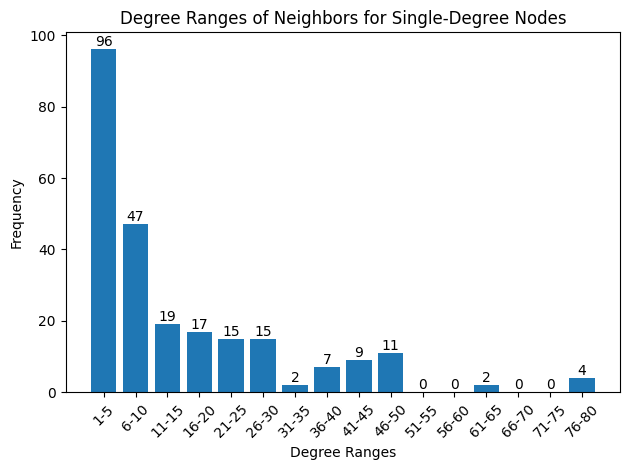

In [ ]:
# Initialize degree range counts
degree_range_counts = {range_: 0 for range_ in [(1, 5), (6, 10), (11, 15), (16, 20), (21, 25), (26, 30), (31, 35), (36, 40), (41, 45), (46, 50), (51, 55), (56, 60), (61, 65), (66, 70), (71, 75), (76, 80)]}  # Adjust the ranges as needed

# Count the degree ranges of neighbors for single-degree nodes
for node in nodes_with_degree_1:
    neighbors = list(G.neighbors(node))
    for neighbor in neighbors:
        neighbor_degree = G.degree(neighbor)
        for range_ in degree_range_counts:
            if range_[0] <= neighbor_degree <= range_[1]:
                degree_range_counts[range_] += 1
                break  # Stop searching for the range once found

# Plot the histogram
bars = plt.bar(range(len(degree_range_counts)), degree_range_counts.values(), align='center')
plt.xticks(range(len(degree_range_counts)), [f"{start}-{end}" for start, end in degree_range_counts.keys()], rotation=45)
plt.xlabel('Degree Ranges')
plt.ylabel('Frequency')
plt.title('Degree Ranges of Neighbors for Single-Degree Nodes')

# Add values on top of each bar
for bar, value in zip(bars, degree_range_counts.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

From the above distribution it appears that most single-degree nodes have formed a connection with nodes in a closer degree range. After that there has been a stark decline in further ranges, decreasing almost monotonously, but then again rising a bit for some normal high degree value. For abnormal high degree, the connection with single-degree nodes is less.  
You may relate this with the concept of small connecting with small and large connecting with large. It would be more efficient for important nodes to be connected to important nodes as that could yield the greatest investment-ouput ratio, and would also cater to a much larger group of commuters. The lesser nodes can still reach their nearest significant station but mostly by passing through other stations of relative importance.  
We can't just connect every station to only important centres as it would lead to a star network, and for our railway network it would mean too much traffic than a junction can quite possibly handle.

# Is the graph fully connected?

Well, I mean it has to, right? It's a railways network it would not make sense that we can't reach a station from another station, even if it requires multiple hops.
But we also have a gut feeling that this won't be the case (since there are already zero degree nodes).  


In [ ]:
# Get the number of connected components
num_components = nx.number_connected_components(G)

# Print the number of connected components
print("Number of connected components:", num_components)

Number of connected components: 27


The railway network can be divided into **27 disjoint components**. Didn't see that one coming. We have 6 stations with no train passing through them so there would be atleast 7 CCs. For others, we need to plot and see the disconnectivity

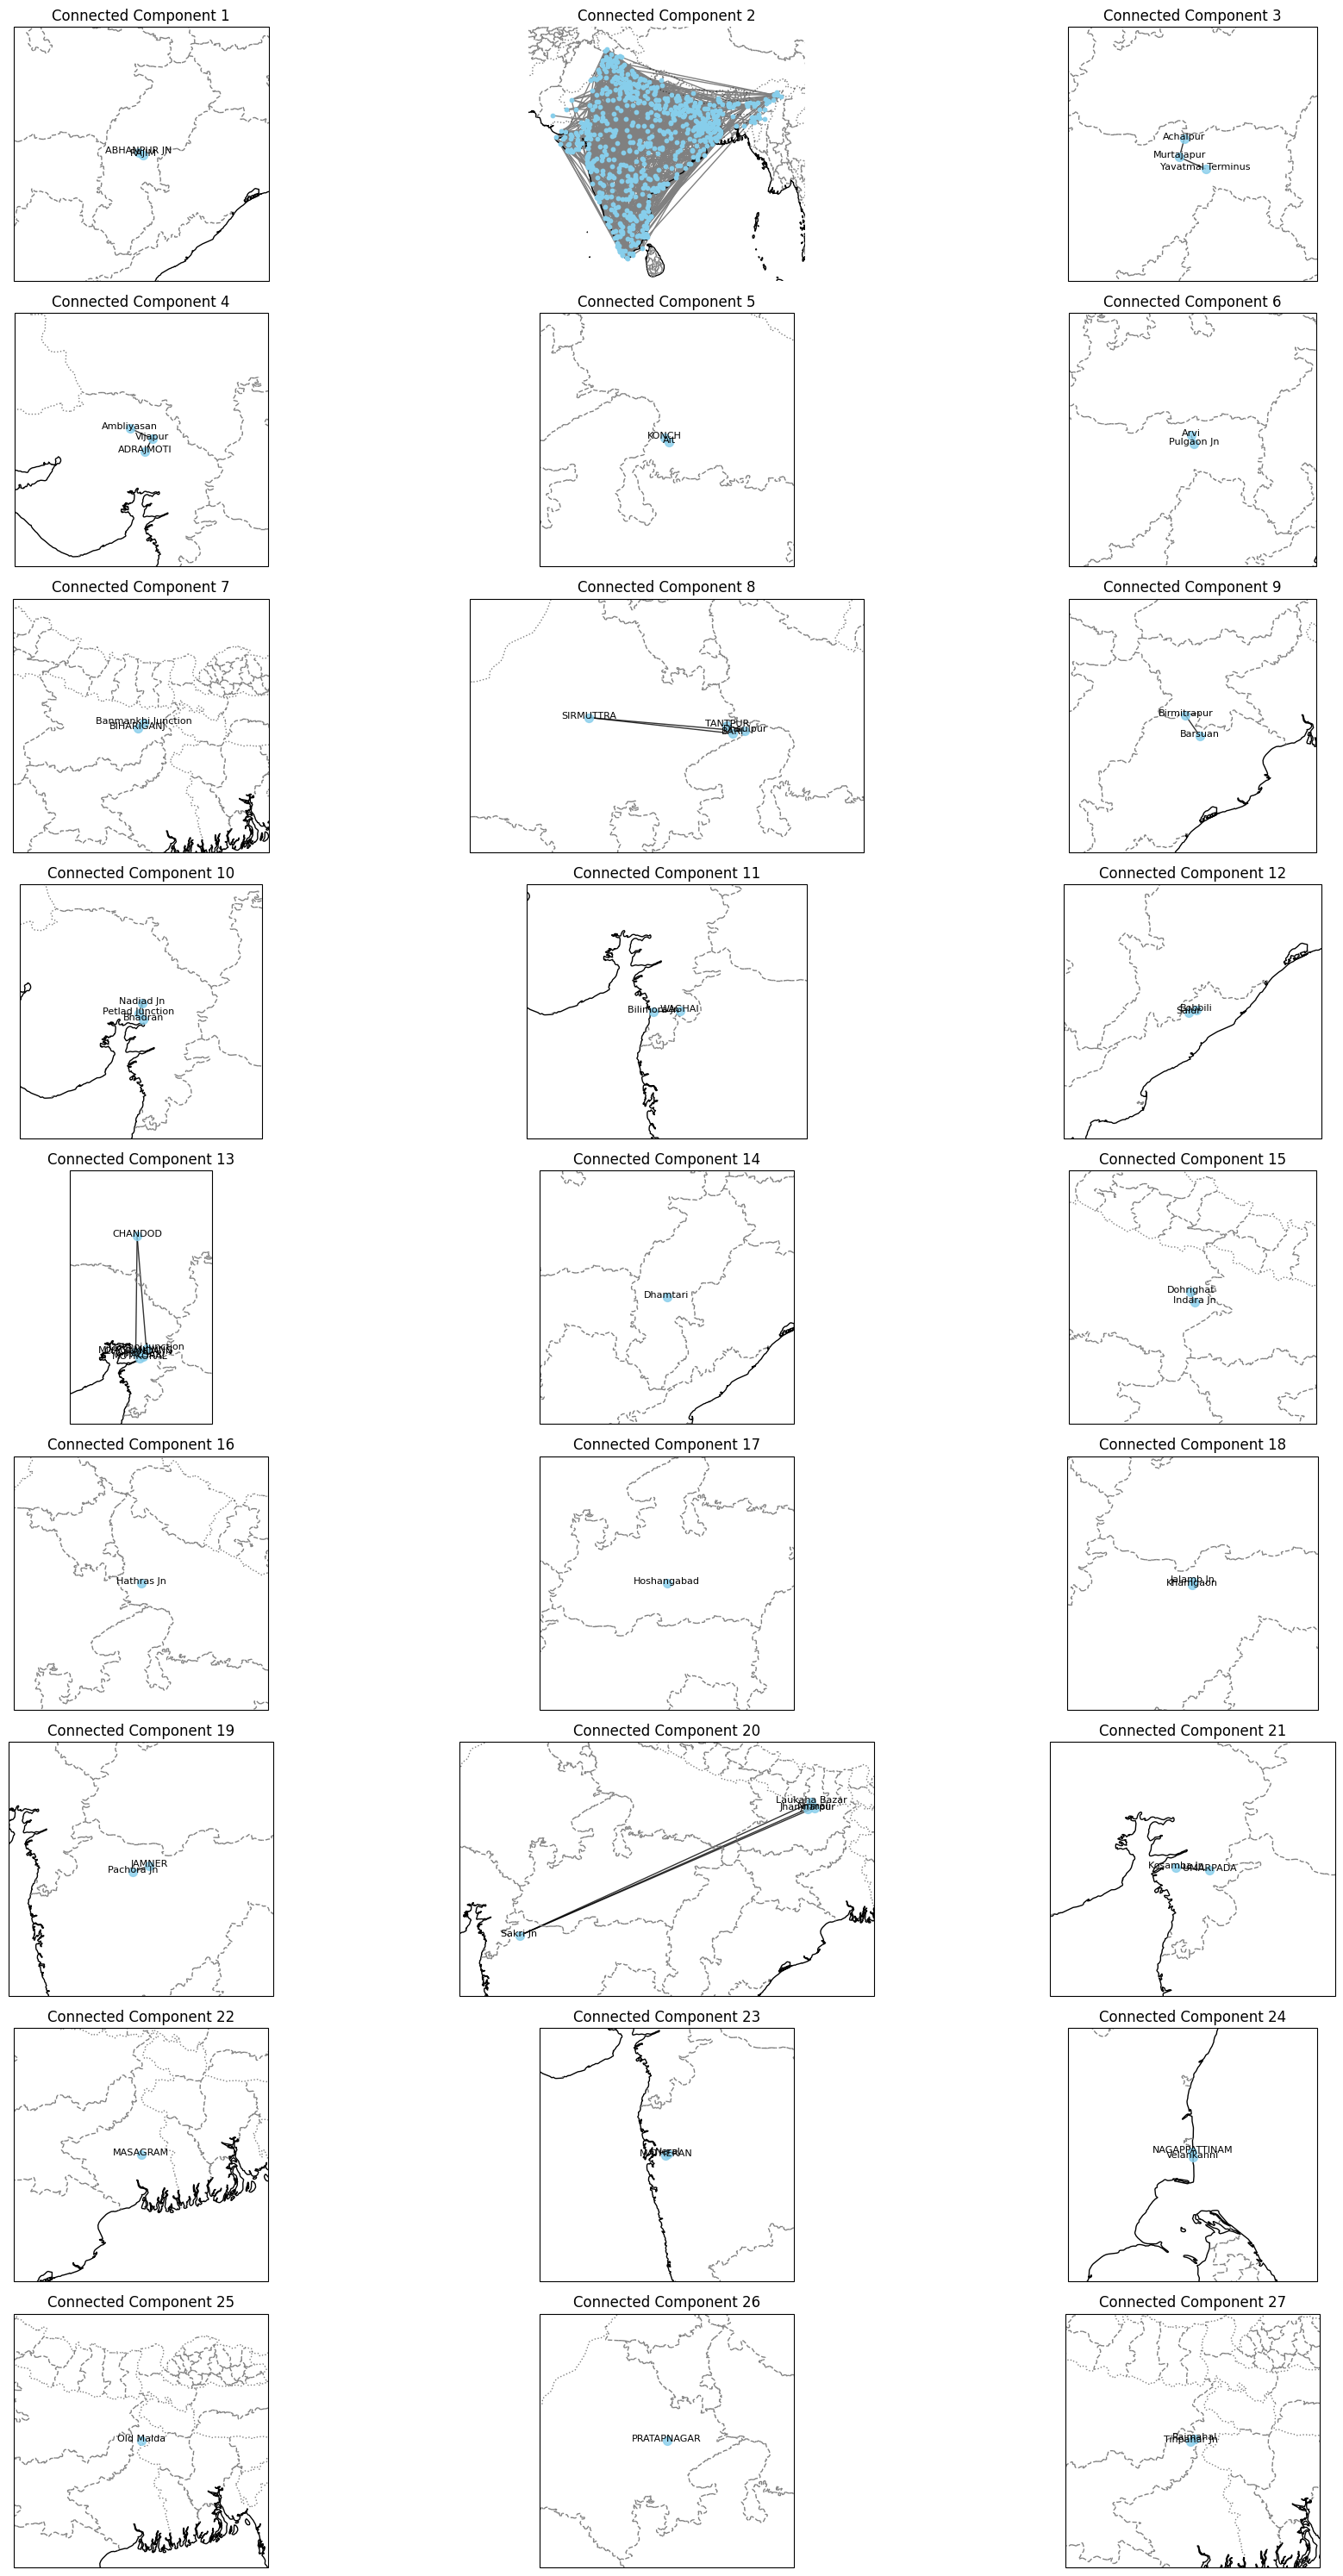

In [ ]:
# Get the connected components
connected_components = list(nx.connected_components(G))

# Create a 9x3 subplot grid
fig, axs = plt.subplots(9, 3, figsize=(20, 30), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten the subplot grid
axs = axs.flatten()

# Setting manual margins
margins = [4, 0, 3.2, 2.8, 2.5, 4, 4, 2.8, 3.2, 2.5, 2.5, 2.5, 2, 4, 3.2, 4, 4, 3.3, 3.2, 2.5, 2, 3.5, 2.8, 2, 4, 4, 3.1]

# Plot each connected component separately
for i, component in enumerate(connected_components):
    ax = axs[i]
    if len(component) <= 10:
        # If the component has less than or equal to 10 nodes, display their names, increase node size, and darken edge color
        for node in component:
            pos = G.nodes[node]['pos']
            name = G.nodes[node]['label']
            ax.text(pos[0], pos[1], name, fontsize=8, ha='center', transform=ccrs.PlateCarree())
        nx.draw_networkx_nodes(G.subgraph(component), pos=nx.get_node_attributes(G, 'pos'), ax=ax, node_color='skyblue', node_size=50, alpha=0.8)
        nx.draw_networkx_edges(G.subgraph(component), pos=nx.get_node_attributes(G, 'pos'), ax=ax, edge_color='black', alpha=0.8)

        # Calculate the extent based on node positions with a slightly increased margin
        min_lon = min(pos[0] for node, pos in nx.get_node_attributes(G, 'pos').items() if node in component)
        max_lon = max(pos[0] for node, pos in nx.get_node_attributes(G, 'pos').items() if node in component)
        min_lat = min(pos[1] for node, pos in nx.get_node_attributes(G, 'pos').items() if node in component)
        max_lat = max(pos[1] for node, pos in nx.get_node_attributes(G, 'pos').items() if node in component)

        margin = margins[i]
        ax.set_extent([min_lon - margin, max_lon + margin, min_lat - margin, max_lat + margin], crs=ccrs.PlateCarree())

    else:
        # If the component has more than 10 nodes, plot it with a unique color
        subgraph = G.subgraph(component)
        pos = {node: G.nodes[node]['pos'] for node in subgraph.nodes}
        nx.draw(subgraph, pos, ax=ax, with_labels=False, node_color='skyblue', node_size=10, edge_color='gray')

    # Plot Indian map in each subplot
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
    ax.add_feature(cfeature.COASTLINE)

    # Add state boundaries
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='10m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray', linestyle='--')

    ax.set_title(f"Connected Component {i+1}")

# Hide empty subplots
for ax in axs[len(connected_components):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Well from the above plot it is clear that there is only one Giant Connected Cluster in the railway network, as one would think. All the other disconnection from these are either stations through which train don't pass, or some small route going between handful of stations.  
Come to think of reasons for the later, it could be due to the connected component being present in some region slightly cut off or inaccessible from the main subnetwork. For some places like a high plateau or a mountain range it would be hard to set up rails to them, but there could be intra-region railways there (like toy trains we have heard of). And other possible reason is that for some sparsely populated areas there won't be good cost-outcome tradeoff for setting railway connections to some more populated centres. In this areas other means of travel like bus would have been found to be more economical, hence they were probably cut-off from the main subnetwork. But there could be some up-down shift between such cities (like Jamner and Panchora), and thus a train must commute between them for easy travel for the residents of the city.

# What if I want to go from any station to any other station



Our country is vast. So it is an interesting question to see how well our railway network is distributed so that it eases the passengers travel time no matter how far or close they need to travel.  
Let us see how many rail routes we need to take to go from one city (or simply a station to another). It wouldn't make sense to compare between disjoint rail routes so lets focus this observation on the greatest connected component.  
To do this we are planning to use Flyod Warshall's algorithm to find shortest paths between all pairs of stations. We are storing this result so that we can perform further calculations and derive observations from it later on.

In [ ]:
import random

# Get the connected components
connected_components = list(nx.connected_components(G))

# Create a new graph object for the GCC
GCC = G.subgraph(connected_components[1]).copy()

# Reduce edge weights to 1 in the GCC
for u, v, data in GCC.edges(data=True):
    data['weight'] = 1

# GCC = GCC.subgraph(random.sample(GCC.nodes(), 10))

In [ ]:
# Get the number of nodes in the graph
num_nodes = len(GCC.nodes())
print(num_nodes)

# Initialize the distance matrix with infinity values
dist_matrix = np.full((num_nodes, num_nodes), np.inf)

# Set the diagonal elements to 0
np.fill_diagonal(dist_matrix, 0)

# Update the distance matrix with unit distance for all edges
for u, v in GCC.edges():
    u_index = list(GCC.nodes()).index(u)
    v_index = list(GCC.nodes()).index(v)
    dist_matrix[u_index, v_index] = 1
    dist_matrix[v_index, u_index] = 1

# Implement the Floyd-Warshall algorithm
for k in range(num_nodes):
    for i in range(num_nodes):
        for j in range(num_nodes):
            dist_matrix[i, j] = min(dist_matrix[i, j], dist_matrix[i, k] + dist_matrix[k, j])

# Store the result appropriately (for example, as a dictionary of dictionaries)
all_pairs_shortest_paths = {}
for i, node_i in enumerate(GCC.nodes()):
    all_pairs_shortest_paths[node_i] = {}
    for j, node_j in enumerate(GCC.nodes()):
        all_pairs_shortest_paths[node_i][node_j] = dist_matrix[i, j]

# Convert the distance matrix to a dictionary of Pandas Series
all_pairs_shortest_paths = {}
for node_i in GCC.nodes():
    distances = {GCC.nodes[node_j]['label']: dist_matrix[i, j] for j, node_j in enumerate(GCC.nodes())}
    distances_series = pd.Series(distances)
    all_pairs_shortest_paths[GCC.nodes[node_i]['label']] = distances_series

# Create a DataFrame from the dictionary
df_shortest_paths = pd.DataFrame(all_pairs_shortest_paths)

# Display the DataFrame
print("All pairs shortest paths:")
print(df_shortest_paths)

In [ ]:
df_shortest_paths += 1
df_shortest_paths.values[[range(num_nodes)], [range(num_nodes)]] = 0

# Display the DataFrame
print("All pairs shortest paths:")
print(df_shortest_paths)

All pairs shortest paths:
                 Abohar  Abu Road  Achhnera Jn  Adilabad  Adra Jn  \
Abohar              0.0       3.0          3.0       3.0      3.0   
Abu Road            4.0       0.0          4.0       4.0      4.0   
Achhnera Jn         4.0       4.0          0.0       4.0      4.0   
Adilabad            3.0       3.0          3.0       0.0      3.0   
Adra Jn             3.0       3.0          3.0       3.0      0.0   
...                 ...       ...          ...       ...      ...   
Warangal            4.0       4.0          4.0       4.0      4.0   
WARASEONI           4.0       4.0          4.0       4.0      4.0   
Wardha Jn           4.0       4.0          4.0       4.0      4.0   
Yamuna Bdg Agra     4.0       4.0          4.0       4.0      4.0   
Yesvantpur Jn       1.0       1.0          1.0       1.0      1.0   

                 Adrsh Ngr Delhi  AGARTALA  Agra Cantt  Agra Fort  \
Abohar                       3.0       3.0         3.0        3.0   
Abu Roa

In [ ]:
# Calculate the average shortest path distance
average_distance = df_shortest_paths.mean().mean()

# Calculate the maximum shortest path distance
max_distance = df_shortest_paths.max().max()

print("Average shortest path distance:", average_distance)
print("Maximum shortest path distance:", max_distance)

Average shortest path distance: 3.579010935378
Maximum shortest path distance: 6.0


This is a very interesting observation that to reach from one station to another, no matter at what extremes the stations be on the Indian subcontinent, we would roughly need to pass through 3 stations to reach that location. And the maximum is only 6! (as sir had mentioned in the first class, verified 🙃)

# Assessing the Robustness of the Indian Railway Network

We are interested in finding how resilient is the Indian railway network to the removal of stations based on their geographic location. Based on this, we aim to highlight which stations have the highest impact on network connectivity when removed based on geographic location

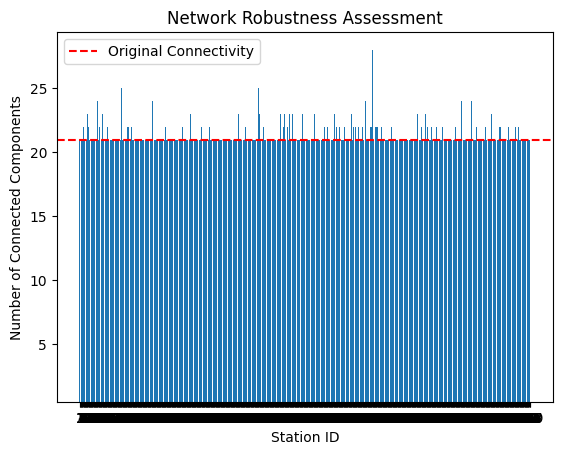

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Load the edges weighted dataset
edges_df = pd.read_csv('edgesweighted.csv')

# Load the dataset with latitude and longitude
latlong_df = pd.read_csv('datawithlatlong.csv')

# Create a graph using networkx
G = nx.from_pandas_edgelist(edges_df, 'Source', 'Target', ['Weight', 'Type'])

# Add latitude and longitude as node attributes
latlong_dict = dict(zip(latlong_df['Id'], zip(latlong_df['LAT'], latlong_df['LON'])))
nx.set_node_attributes(G, latlong_dict, 'latlong')

# Define a function to remove stations based on their geographic location
def simulate_removal_by_geography(graph, region):
    nodes_to_remove = [node for node, attrs in graph.nodes(data=True) if node == region]
    graph_copy = graph.copy()
    graph_copy.remove_nodes_from(nodes_to_remove)
    return graph_copy

# Define a function to assess network robustness
def assess_robustness(graph):
    # Measure network connectivity metrics
    connectivity_metrics = {
        'original': nx.number_connected_components(graph),
    }

    # Simulate removal and measure metrics for each region
    for region in set(latlong_df['Id']):
        graph_copy = simulate_removal_by_geography(graph, region)
        connectivity_metrics[region] = nx.number_connected_components(graph_copy)

    return connectivity_metrics

# Assess network robustness
original_metrics = assess_robustness(G)

# Visualize results
labels = [''] + list(map(str, set(latlong_df['Id'])))
values = [original_metrics['original']] + [original_metrics[region] for region in set(latlong_df['Id'])]

fig, ax = plt.subplots()
ax.bar(labels, values)
ax.set_xlabel('Station ID')  # Change x-axis label
ax.set_ylabel('Number of Connected Components')
ax.set_title('Network Robustness Assessment')

# Set a minimum value for the y-axis to avoid overlapping with x-axis
plt.ylim(bottom=0.5)

# Highlight the line corresponding to the original network connectivity
ax.axhline(original_metrics['original'], color='red', linestyle='--', label='Original Connectivity')

# Show legend
ax.legend()





The bar chart displays the number of connected components in the Indian railway network under different scenarios where we have removed each of the stations one at a time. We see that removal of certain stations significantly increase the connected components, indicating that removal stations would lead to more non-connectivity stations across the country. We identify the top 10 stations and aim to understand this and try to explain by their geographical or demographical analysis.

<ipython-input-40-00b72c3d7eb7>:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  india = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Figure size 1000x1000 with 0 Axes>

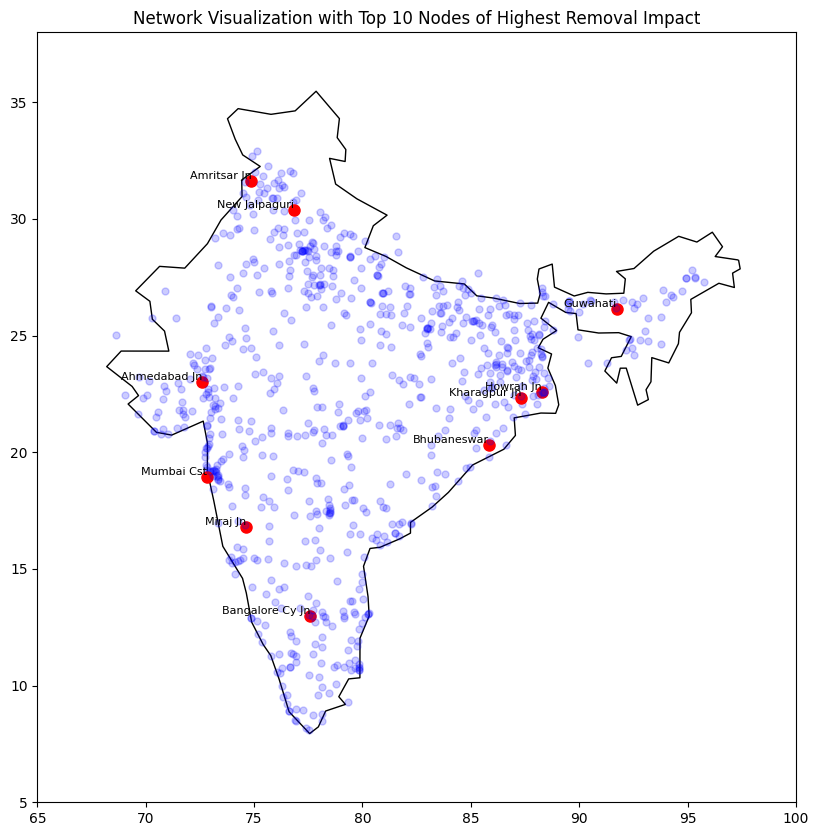

In [ ]:
# Display the network visualization map of India
plt.figure(figsize=(10, 10))
india = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = india[india['name'] == 'India'].plot(figsize=(10, 10), color='white', edgecolor='black')
ax.set_xlim([65, 100])
ax.set_ylim([5, 38])

# Plot nodes
for node, (lat, lon) in latlong_dict.items():
    if node in [top_node for top_node, _ in top_10_nodes]:
        plt.plot(lon, lat, 'ro', markersize=8)
        plt.text(lon, lat, str(latlong_df[latlong_df['Id'] == node]['Stations'].values[0]), fontsize=8, color='black', ha='right', va='bottom')
    else:
        plt.plot(lon, lat, 'bo', markersize=5, alpha=0.2)

plt.title('Network Visualization with Top 10 Nodes of Highest Removal Impact')
plt.show()


Red nodes represent the top 10 stations with the highest removal impact, labeled by their names. Blue nodes are other stations, with transparency indicating their lighter impact when removed.

Stations like Ahmedabad Junction, Mumbai CST, and Howrah Junction act as central transportation hubs in major metropolitan areas. Bangalore City Junction, Bhubaneshwar Junction, and Guwahati serve as key connectors for their respective regions. Amritsar Junction in the north and strategically located Kharagpur Junction play vital roles in regional connectivity. New Jalpaiguri serves as a gateway to tourist destinations, and Miraj Junction is crucial for transportation in Maharashtra.